In [1]:
import cv2
import numpy as np
import skimage
from skimage.exposure import histogram

In [2]:
cv2.__version__, skimage.__version__

('4.1.1', '0.17.1')

In [661]:
image = cv2.imread("warped.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
h, w = image.shape

In [647]:
boxes = image[int(h * 0.102) : int(h * 0.13), int(w * 0.118) : int(w * 0.747)]

print(boxes.shape)

offset = int(boxes.shape[1] // 11)
print(offset)

boxes.shape[1] % 11

print(363 / 11, 366 % 11)

box = boxes[:, offset * 10 : offset * 11]

cv2.imwrite("box.png", box)

(23, 363)
33
33.0 3


True

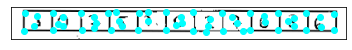

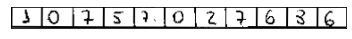

In [727]:
image = cv2.imread("warped.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
h, w = image.shape

boxes_area = image[int(h * 0.095) : int(h * 0.14), int(w * 0.09) : int(w * 0.77)]
cv2.imwrite("boxes.png", boxes_area)

from matplotlib import pyplot as plt
from skimage import measure
from skimage.feature import corner_harris, corner_peaks, corner_subpix

coords = corner_peaks(corner_harris(boxes_area), min_distance=5, threshold_rel=0.1)
# coords_subpix = corner_subpix(boxes_area, coords, window_size=10)


fig, ax = plt.subplots()
ax.imshow(boxes_area, cmap=plt.cm.gray)
ax.plot(
    coords[:, 1], coords[:, 0], color="cyan", marker="o", linestyle="None", markersize=6
)
# ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
ax.axis()
ax.set_xticks([])
ax.set_yticks([])
plt.show()

miny, maxy = min(coords[:, 0]), max(coords[:, 0])
minx, maxx = min(coords[:, 1]), max(coords[:, 1])

box = boxes_area[miny:maxy, minx:maxx]


# contours = measure.find_contours(box, 250, fully_connected='low')
# print(len(contours))
# digits = []
# for cnt in contours:
#     approx = measure.approximate_polygon(cnt, 16)
#     if 4 <= len(approx) <= 7:
#         digits.append(cnt)
# contours = digits
# print(len(contours))


fig, ax = plt.subplots()
ax.imshow(box, cmap=plt.cm.gray)

# for contour in contours:
#     ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis()
ax.set_xticks([])
ax.set_yticks([])
plt.show()

# offset = int(box.shape[1] // 11)
# print(offset)

# box.shape[1] % 11

# print(363 / 11, 366 % 11)

# box = box[:, offset * 10 : offset * 11]

# cv2.imwrite("box.png", box)

In [730]:
lines = cv2.HoughLinesP(
    image=box,
    rho=1,
    theta=np.pi / 180,
    threshold=100,
    lines=np.array([]),
    minLineLength=box.shape[0]*0.8,
    maxLineGap=box.shape[1]//11 - 5,
)

box_lines = box.copy()
a, b, c = lines.shape
for i in range(a):
    cv2.line(
        box_lines,
        (lines[i][0][0], lines[i][0][1]),
        (lines[i][0][2], lines[i][0][3]),
        (0, 0, 255),
        3,
        cv2.LINE_AA,
    )
cv2.imwrite("lines.png", box_lines)

True

30
12


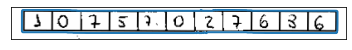

In [684]:
image = cv2.imread("warped.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
h, w = image.shape

boxes_area = image[int(h * 0.095) : int(h * 0.14), int(w * 0.09) : int(w * 0.77)]
cv2.imwrite("boxes.png", boxes_area)

from matplotlib import pyplot as plt
from skimage import measure

contours = measure.find_contours(boxes_area, 250, fully_connected="high")
print(len(contours))
boxes = []
for cnt in contours:
    approx = measure.approximate_polygon(cnt, 16)
    if 4 <= len(approx) <= 6:
        boxes.append(cnt)
contours = boxes
print(len(contours))


def contour_area(cnt):
    # Expand numpy dimmensions
    c = np.expand_dims(cnt.astype(np.float32), 1)
    # Convert it to UMat object
    c = cv2.UMat(c)
    return cv2.contourArea(c)


contours.sort(key=lambda c: contour_area(c), reverse=True)
contour = contours[0]

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(boxes_area, cmap=plt.cm.gray)

ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
# for n, contour in enumerate(contours):
#     ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis("image")
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [652]:
boxes_area = image[int(h * 0.095) : int(h * 0.14), int(w * 0.09) : int(w * 0.77)]
cv2.imwrite("boxes.png", boxes_area)

boxes_blank = cv2.imread("boxes_blank.png")
boxes_blank = cv2.cvtColor(boxes_blank, cv2.COLOR_BGR2GRAY)
boxes_blank = cv2.resize(boxes_blank, boxes_area.shape)

MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15

# Detect ORB features and compute descriptors.
orb = cv2.ORB_create(nfeatures=MAX_FEATURES)  # , fastThreshold=1, edgeThreshold=1)
keypoints1, descriptors1 = orb.detectAndCompute(boxes_area, None)
keypoints2, descriptors2 = orb.detectAndCompute(boxes_blank, None)
print(len(keypoints1), len(keypoints2))

# Match features.
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
matches = matcher.match(descriptors1, descriptors2, None)

# Sort matches by score
matches.sort(key=lambda x: x.distance, reverse=False)

# Remove not so good matches
numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
matches = matches[:numGoodMatches]

# Draw top matches
imMatches = cv2.drawMatches(
    boxes_area, keypoints1, boxes_blank, keypoints2, matches, None
)
cv2.imwrite("matches.png", imMatches)

0 0


True

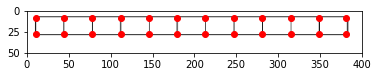

In [653]:
image = cv2.imread("warped.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
h, w = image.shape
boxes_area = image[int(h * 0.095) : int(h * 0.14), int(w * 0.09) : int(w * 0.77)]
h, w = boxes_area.shape
cv2.imwrite("boxes.png", boxes_area)

boxes_blank = cv2.imread("boxes_blank.png")
boxes_blank = cv2.cvtColor(boxes_blank, cv2.COLOR_BGR2GRAY)
boxes_blank = cv2.resize(boxes_blank, (w, h))
cv2.imwrite("boxes_blank_resized.png", boxes_blank)

from matplotlib import pyplot as plt
from skimage.feature import corner_harris, corner_peaks, corner_subpix

coords = corner_peaks(corner_harris(boxes_blank), min_distance=5, threshold_rel=0.01)
coords_subpix = corner_subpix(boxes_blank, coords, window_size=10)


fig, ax = plt.subplots()
ax.imshow(boxes_blank, cmap=plt.cm.gray)
ax.plot(
    coords[:, 1], coords[:, 0], color="red", marker="o", linestyle="None", markersize=6
)
# ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
ax.axis((0, 400, 50, 0))
plt.show()

In [654]:
boxes = cv2.imread("modelo3.png")
boxes = cv2.cvtColor(boxes, cv2.COLOR_BGR2GRAY)
h, w = boxes.shape

boxes = boxes[int(0.12 * h) : int(0.165 * h), int(0.135 * w) : int(0.74 * w)]


cv2.imwrite("boxes_blank.png", boxes)

True

In [655]:
from skimage import transform
from skimage.feature import (
    ORB,
    corner_harris,
    corner_peaks,
    match_descriptors,
    plot_matches,
)

image = cv2.imread("warped.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
h, w = image.shape
boxes_area = image[int(h * 0.095) : int(h * 0.14), int(w * 0.09) : int(w * 0.77)]
h, w = boxes_area.shape
cv2.imwrite("boxes.png", boxes_area)

boxes_blank = cv2.imread("boxes_blank.png")
boxes_blank = cv2.cvtColor(boxes_blank, cv2.COLOR_BGR2GRAY)
boxes_blank = cv2.resize(boxes_blank, (w, h))
cv2.imwrite("boxes_blank_resized.png", boxes_blank)

descriptor_extractor = ORB(
    n_keypoints=100, harris_k=0.01, fast_n=2, fast_threshold=0.01, downscale=0.8
)

descriptor_extractor.detect_and_extract(boxes_blank)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(boxes_area)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

print(len(keypoints1), len(keypoints2))
matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)

fig, ax = plt.subplots(nrows=2, ncols=1)

plt.gray()

plot_matches(ax[0], img1, img2, keypoints1, keypoints2, matches12)
ax[0].axis("off")
ax[0].set_title("Original Image vs. Transformed Image")

# warped = warp(boxes_area, np.array([row_coords + v, col_coords + u]), mode="nearest")
# print(warped.shape)
# cv2.imwrite("boxes.png", warped)

ValueError: scale factor must be greater than 1